توجه: فقط قسمت های خواسته شده را تکمیل کنید و همراه فایل خود مدل آموزش دیده را ارسال کنید.

هدف این تمرین :


1.   ساخت دیتاست مورد نیاز و نوشتن کلاس دیتاست
2.   Augmentation
3.   نوشتن مدل دسته بندی 3 کلاسه با استفاده از چند کلاس پایتون



In [1]:
## download data
#%%capture

#!wget http://data.csail.mit.edu/places/ADEchallenge/release_test.zip
#!wget http://data.csail.mit.edu/places/ADEchallenge/ADEChallengeData2016.zip
#!unzip ADEChallengeData2016.zip
#!unzip release_test.zip
#!pip install mmengine

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import glob

from cv2 import imread as IM
from os import path

from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import random
from torch.utils.data import random_split

from random import randint
import matplotlib.pyplot as plt
import tqdm

## Data Generation

## Functions

### 1. Displacement
This function performs a random displacement on the input image by shifting its pixels in both the horizontal (x) and vertical (y) directions. The values of displacement (x, y) are randomly chosen within the range of [1, 180].

### 2. Rotation
The rotation function rotates the input image by a random angle in degrees. The center of rotation is the image center. The angle is randomly chosen within the range of [1, 180].

### 3. Scaling
This function scales the input image by a random factor. The scaling factor (s) is randomly chosen from a set of predefined values [0.1, 0.2, 0.5, 2, 4].

### 4. Brightness
Adjusts the brightness of the input image by applying a random scaling factor (alpha) and adding a random offset (beta). The alpha value is randomly chosen within the range of [1, 3], and the beta value is chosen within the range of [1, 60].

### 5. Blurring
Applies Gaussian blur to the input image using a kernel size of (5, 5).

### 6. Gaussian Noise
Adds random Gaussian noise to the input image. The mean and variance of the noise are randomly chosen within the range of [0, 2].

These augmentation (Brightness,Blurring, Gaussian Noise) functions can be used to generate diverse training samples for machine learning models, making them more robust and invariant to variations in the input data.


In [17]:
# function 1
def displacement(img):
    rows, cols = img.shape[:2]
    x=random.randint(1, 180)
    y=random.randint(1, 180)
    M = np.float32([[1, 0, x], [0, 1, y]]) # displacement (x,y)
    img = cv2.warpAffine(img, M, (cols, rows),borderMode=cv2.BORDER_REFLECT)
    return img

# function 2
def rotation(img):
    rows, cols = img.shape[:2]
    angle = random.randint(1, 180)
    M = cv2.getRotationMatrix2D((cols/2, rows/2), angle, 1) # rotate angle degrees
    img = cv2.warpAffine(img, M, (cols, rows),borderMode=cv2.BORDER_REFLECT)
    return img

# function 3
def scaling(img):
    s=random.choice([0.1,0.2,0.5,2,4])
    img = cv2.resize(img, None, fx=s, fy=s, interpolation = cv2.INTER_CUBIC) # scale sx
    return img

# function 4
def Brightness(img):
    alpha=1
    beta=random.randint(1, 5)
    img = cv2.convertScaleAbs(img, alpha, beta) # increase brightness by beta
    return img

# function 5
def bluring(img):
    img = cv2.GaussianBlur(img, (5, 5), 0) # apply Gaussian blur
    return img

# function 6
def gaussian_noise(img):
    row, col, ch = img.shape
    mean = random.uniform(0, 0.1)
    sigma = random.uniform(0.1, 0.2)
    gauss = np.random.normal(100, 1, (row, col, ch))
    gauss = gauss.reshape(row, col, ch)
    img = img + gauss
    #print(gauss)
    return img

## Custom Dataset for Image Augmentation and Transformation Labeling

### Objective
The goal of this custom dataset is to create a dataset for training a model to recognize different image transformations applied to the input images. The transformations include Displacement, Rotation, and Scaling. The dataset is generated by applying random augmentations to the input images and labeling them accordingly.

### Dataset Structure
- **Data Path:** The dataset is initialized with a path to a directory containing image files (in this case, JPEG files).
- **Image Paths:** All image paths within the specified directory are obtained using the `glob` module.
- **Transforms:** A set of image transformations is defined using the `transforms.Compose` class from PyTorch. This includes converting images to tensors, normalizing pixel values, and resizing images to (224, 224) with antialiasing.

### Augmentation and Labeling
- **__getitem__ Method:** For each image in the dataset, the `__getitem__` method loads the original image. It then randomly decides whether to apply augmentations (Brightness, Blurring, Gaussian Noise) to the original image.
- **Transformation Application:** After augmentations, the original image undergoes a random sequence of transformations (Displacement, Rotation, Scaling). The specific transformations applied are recorded as labels.

### Transformation Labeling
- **apply_transformations Method:** This method takes an image and randomly applies a sequence of transformations based on the random choices made. The labels indicate which transformations were applied (Displacement, Rotation, Scaling).



In [4]:
class CustomDataset(Dataset):
    def __init__(self, data_path,mode):
        self.mode=mode
        self.data_path = data_path
        self.image_paths = glob.glob(os.path.join(data_path, "*.jpg"))
        self.transforms = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            transforms.Resize((224, 224),antialias=True)
        ])


    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        original_img = cv2.imread(img_path)


        if random.choice([0, 1])==1:
          original_img=Brightness(bluring(gaussian_noise(original_img)))

        transformed_img,label = self.apply_transformations(original_img)

        original_img = self.transforms(original_img)
        transformed_img = self.transforms(transformed_img)
        label = torch.tensor(label)

        return original_img, transformed_img,label

    def apply_transformations(self, img):
        random_transforms = [random.choice([0, 1]) for _ in range(3)]

        if random_transforms[0]==1:
            img = displacement(img)
        if random_transforms[1]==1:
            img = rotation(img)
        if random_transforms[2]==1:
          img = scaling(img)

        return img,random_transforms




## Image Transformation Recognition Dataset

- Training: './ADEChallengeData2016/images/training/'
- Validation: './ADEChallengeData2016/images/validation/'
- Test: './release_test/testing/'

- Training Dataset: `dataset_train` with mode 'Training'
- Validation Dataset: `dataset_val` with mode 'Validation'
- Test Dataset: `dataset_test` with mode 'Testing'

- Data Loaders:
  - Training: `train_loader` (Batch Size: 16, Shuffle: True)
  - Validation: `val_loader` (Batch Size: 16, Shuffle: False)
  - Test: `test_loader` (Batch Size: 16, Shuffle: True)


In [5]:
training_data_path = './ADEChallengeData2016/images/training/'

validation_data_path = './ADEChallengeData2016/images/validation/'

test_data_path= './release_test/testing/'

dataset_train = CustomDataset(training_data_path,'Training')
dataset_val = CustomDataset(validation_data_path,'Validation')
dataset_test= CustomDataset(test_data_path,'Testing')

subset_size =5000
dataset_train_subset = torch.utils.data.Subset(dataset_train, range(subset_size))
dataset_val_subset = torch.utils.data.Subset(dataset_val, range(1000))
dataset_test_subset = torch.utils.data.Subset(dataset_test, range(1000))


train_loader = DataLoader(dataset_train_subset, batch_size=32, shuffle=True)
test_loader= DataLoader(dataset_test_subset, batch_size=8, shuffle=False)
val_loader = DataLoader(dataset_val_subset, batch_size=8, shuffle=True)


## Visualize dataset
Show 8 images from train_loader & 8 images from test_loader

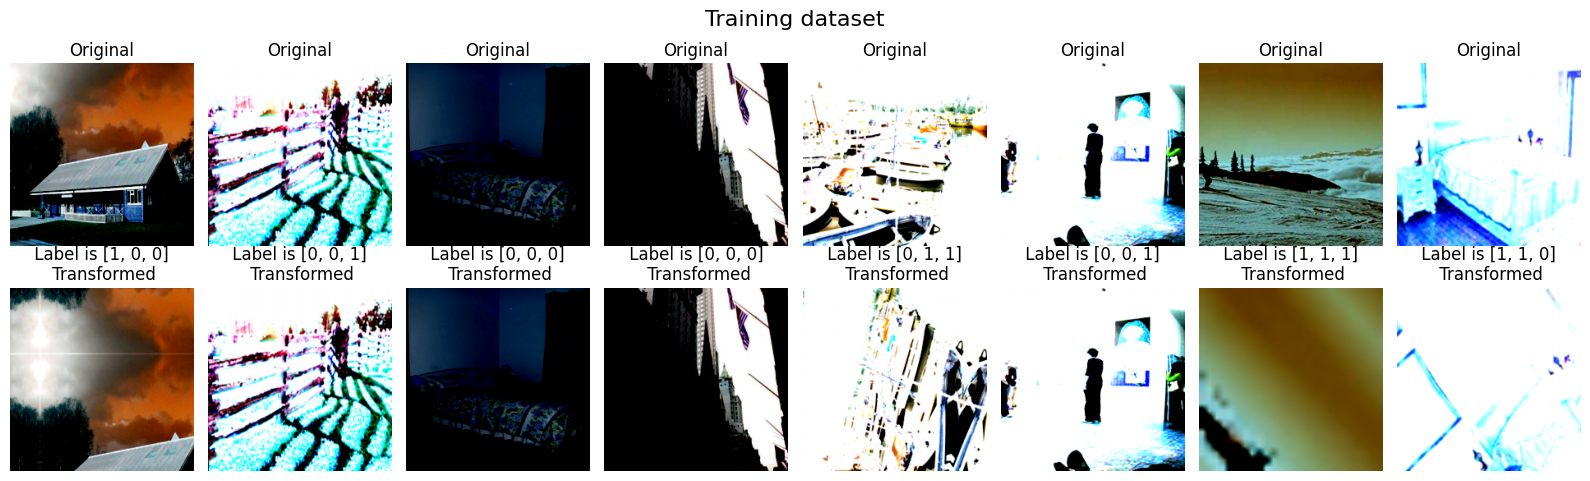

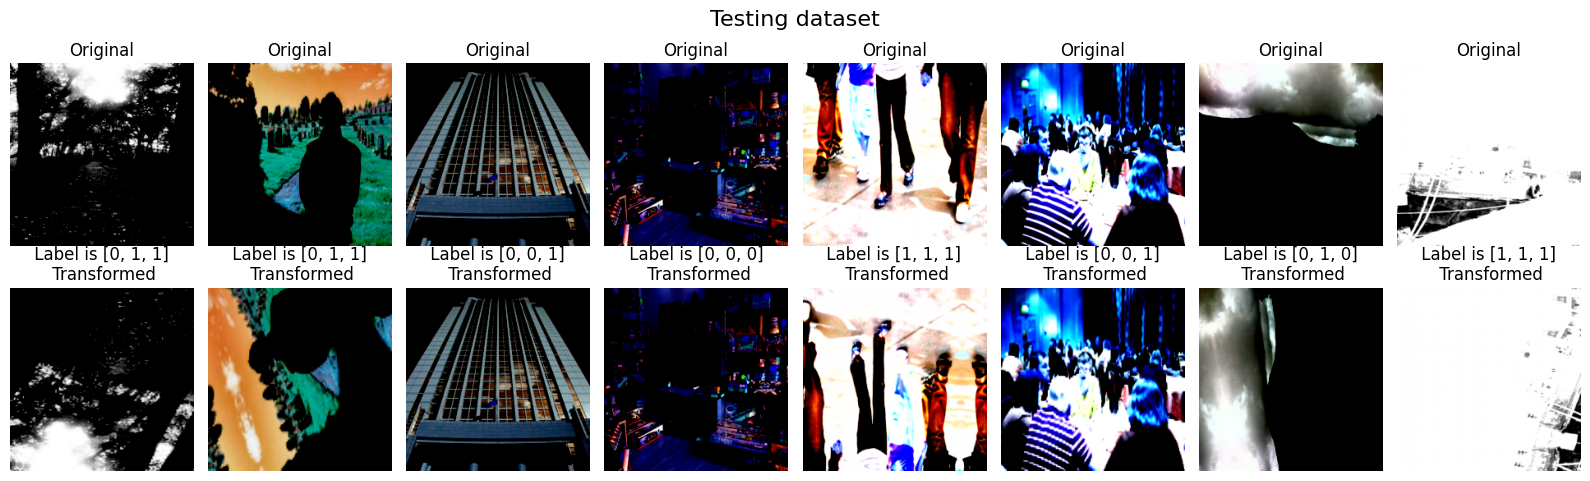

In [6]:
# Function to display images
def show_image(loader,title):
  mean = [0.5,0.5,0.5]
  std = [0.5,0.5,0.5]

  unnormalize = transforms.Normalize(
      mean=[-m/s for m, s in zip(mean, std)],
      std=[1/s for s in std]
      )

  (img_original,img_transformed,Labels)=next(iter(loader))
  #img_original=unnormalize(img_original)
  #img_transformed=unnormalize(img_transformed)
  img_original=torch.clamp(img_original, 0, 1)
  img_transformed=torch.clamp(img_transformed, 0, 1)


  fig, axes = plt.subplots(2, 8, figsize=(16, 5))
  plt.suptitle(title, fontsize=16)

  for i in range(8):

    axes[0, i].imshow(img_original[i].permute(1, 2, 0))
    axes[0, i].set_title("Original")
    axes[0, i].axis("off")

    axes[1, i].imshow(img_transformed[i].permute(1, 2, 0))
    axes[1, i].set_title(f" Label is {Labels[i].tolist()} \n Transformed")
    axes[1, i].axis("off")


  plt.tight_layout()
  plt.show()

show_image(train_loader,'Training dataset')
show_image(test_loader,'Testing dataset')


##Model

در این قسمت میخواهیم یک مدل 3 کلاسه  مطبق شکل زیرکه شامل قسمت های زیر میشود را آموزش دهیم.

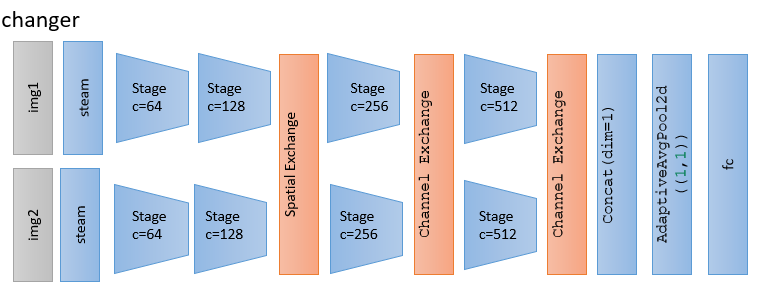

دو کلاس



1.   SpatialExchange
2.   ChannelExchange


 .مطابق شکل زیر ویژگی های دو تصویر را با هم عوض میکنند.


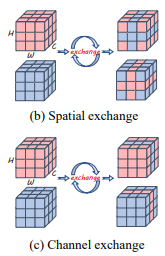

In [7]:
from mmengine.model import BaseModule
class ChannelExchange(BaseModule):
    """
    channel exchange
    Args:
        p (float, optional): p of the features will be exchanged.
            Defaults to 1/2.
    """
    def __init__(self, p=1/2):
        super().__init__()
        assert p >= 0 and p <= 1
        self.p = int(1/p)

    def forward(self, x1, x2):
        N, c, h, w = x1.shape

        exchange_map = torch.arange(c) % self.p == 0
        exchange_mask = exchange_map.unsqueeze(0).expand((N, -1))

        out_x1, out_x2 = torch.zeros_like(x1), torch.zeros_like(x2)
        out_x1[~exchange_mask, ...] = x1[~exchange_mask, ...]
        out_x2[~exchange_mask, ...] = x2[~exchange_mask, ...]
        out_x1[exchange_mask, ...] = x2[exchange_mask, ...]
        out_x2[exchange_mask, ...] = x1[exchange_mask, ...]

        return out_x1, out_x2



class SpatialExchange(BaseModule):
    """
    spatial exchange
    Args:
        p (float, optional): p of the features will be exchanged.
            Defaults to 1/2.
    """
    def __init__(self, p=1/2):
        super().__init__()
        assert p >= 0 and p <= 1
        self.p = int(1/p)

    def forward(self, x1, x2):
        N, c, h, w = x1.shape
        exchange_mask = torch.arange(w) % self.p == 0

        out_x1, out_x2 = torch.zeros_like(x1), torch.zeros_like(x2)
        out_x1[..., ~exchange_mask] = x1[..., ~exchange_mask]
        out_x2[..., ~exchange_mask] = x2[..., ~exchange_mask]
        out_x1[..., exchange_mask] = x2[..., exchange_mask]
        out_x2[..., exchange_mask] = x1[..., exchange_mask]

        return out_x1, out_x2

## block  

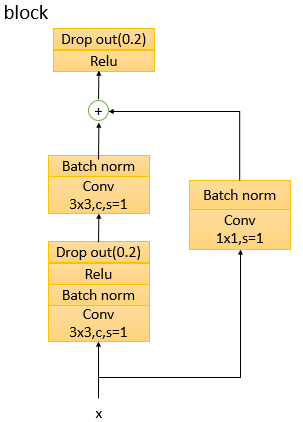

**Values for Convolutional Layers:**

1. **`channel out` size (conv(1*1)):**
   - The value of channel out is`c_out=c`.

2. **`padding` (conv):**
   - The value of `padding=1`, which is equal to one. This is used to preserve spatial dimensions (width and height) of the input image.

**Reason for Using 1x1 Convolution:**

  - Performing linear combinations on input features, which can change the number of channels and transform the output into a different representational space.
  - Reducing the number of parameters and computational operations, leading to faster training and reduced memory usage.
  - Providing a fixed point for applying non-linear operations such as Batch Normalization.




In [18]:
class block(nn.Module):
  def __init__(self,c_in,c_out):
    super(block,self).__init__()
    self.conv3_1=nn.Conv2d(in_channels=c_in,out_channels=c_out,kernel_size=3,stride=1,padding=1)
    self.conv3_2=nn.Conv2d(in_channels=c_out,out_channels=c_out,kernel_size=3,stride=1,padding=1)
    self.conv1=nn.Conv2d(in_channels=c_in,out_channels=c_out,kernel_size=1,stride=1,padding=0)

    self.BN1=nn.BatchNorm2d(num_features=c_out)
    self.BN2=nn.BatchNorm2d(num_features=c_out)
    self.BN3=nn.BatchNorm2d(num_features=c_out)

    self.Relu1=nn.ReLU()
    self.Relu2=nn.ReLU()
    self.Drop_out1=nn.Dropout2d(p=0.2)
    self.Drop_out2=nn.Dropout2d(p=0.2)


  def forward(self,x):

    y=self.conv3_1(x)
    y=self.BN1(y)
    y=self.Relu1(y)
    y=self.Drop_out1(y)

    y=self.conv3_2(y)
    y=self.BN2(y)

    y1=self.conv1(x)
    y1=self.BN3(y1)

    out=self.Relu2(y+y1)
    out=self.Drop_out2(out)

    return out

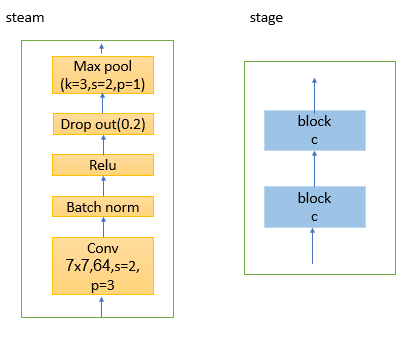

In [9]:
class changer(nn.Module):
  def __init__(self,block,SpatialExchange,ChannelExchange):
    super(changer,self).__init__()

    self.steam=nn.Sequential(
          nn.Conv2d(in_channels=3,out_channels=64,kernel_size=7,stride=2,padding=3),
          nn.BatchNorm2d(num_features=64),
          nn.ReLU(),
          nn.Dropout2d(p=0.2),
          nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
        )

    self.SpatialExchange=SpatialExchange()
    self.ChannelExchange=ChannelExchange()
    self.Block=block

    self.stage1=self._make_stage(64,64)
    self.stage2=self._make_stage(64,128)
    self.stage3=self._make_stage(128,256)
    self.stage4=self._make_stage(256,512)

    self.AVpool=nn.AdaptiveAvgPool2d((1, 1))

    self.fc=nn.Linear(in_features=1024,out_features=3)



  def _make_stage(self,c_in,c_out):
    layers=[self.Block(c_in,c_out),self.Block(c_out,c_out)]

    return nn.Sequential(*layers)




  def forward(self,x1,x2):
    x1,x2=self.steam(x1),self.steam(x2)

    x1,x2=self.stage1(x1),self.stage1(x2)
    x1,x2=self.stage2(x1),self.stage2(x2)

    x1,x2=self.SpatialExchange(x1,x2)

    x1,x2=self.stage3(x1),self.stage3(x2)
    x1,x2=self.ChannelExchange(x1,x2)

    x1,x2=self.stage4(x1),self.stage4(x2)

    x1,x2=self.ChannelExchange(x1,x2)

    out=torch.cat([x1,x2],1)
    out=self.AVpool(out)
    out=torch.squeeze(out)
    out=self.fc(out)

    return out

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model=changer(block,SpatialExchange,ChannelExchange).to(device)

citeration = nn.BCEWithLogitsLoss()
optimizer= optim.Adam(model.parameters(), lr=1e-3)

cuda


##Train & validation


In [11]:
num_epochs=5

Loss_train=[]
acc_train=[]
Loss_val=[]
acc_val=[]

for epoch in range(num_epochs):
  # Training phase
  model.train()
  train_loss = 0.0
  train_correct = 0
  val_correct= 0
  val_loss=0.0

  for originals,transformeds,labels in tqdm.tqdm(train_loader):
    originals,transformeds,labels = originals.to(device),transformeds.to(device),labels.to(device)

    optimizer.zero_grad()
    output=model(originals.to(torch.float32),transformeds.to(torch.float32))

    loss=citeration(output.to(torch.float32),labels.to(torch.float32))
    loss.backward()
    optimizer.step()

    # Thresholding operation
    pred = (nn.functional.sigmoid(output)>0.5).int()
    labels=labels.int()

    train_loss += loss.item()
    train_correct+=torch.sum(torch.eq(pred, labels)).item()

  Loss_train.append(train_loss/len(train_loader))
  acc_train.append(train_correct / (3*len(train_loader.dataset)))

  # Validation phase

  model.eval()

  with torch.no_grad():
    for originals,transformeds,labels in val_loader:
      originals,transformeds,labels = originals.to(device),transformeds.to(device),labels.to(device)
      output=model(originals.to(torch.float32),transformeds.to(torch.float32))

      loss=citeration(output.to(torch.float32),labels.to(torch.float32))

      # Thresholding operation
      pred = (nn.functional.sigmoid(output)>0.5).int()
      labels=labels.int()

      val_loss += loss.item()
      val_correct+=torch.sum(torch.eq(pred, labels)).item()

  Loss_val.append(val_loss/len(val_loader))
  acc_val.append(val_correct / (3*len(val_loader.dataset)))


  print(f'Epoch {epoch + 1}/{num_epochs}, loss_TRAIN ={Loss_train[-1]:.3f},acc_train={acc_train[-1]*100:.2f}, loss_Val ={Loss_val[-1]:.3f},acc_Val={acc_val[-1]*100:.2f}')



100%|██████████| 157/157 [08:38<00:00,  3.30s/it]


Epoch 1/5, loss_TRAIN =0.702,acc_train=50.92, loss_Val =0.657,acc_Val=59.80


100%|██████████| 157/157 [08:36<00:00,  3.29s/it]


Epoch 2/5, loss_TRAIN =0.654,acc_train=59.99, loss_Val =0.624,acc_Val=61.30


100%|██████████| 157/157 [08:27<00:00,  3.23s/it]


Epoch 3/5, loss_TRAIN =0.612,acc_train=63.50, loss_Val =0.580,acc_Val=65.67


100%|██████████| 157/157 [08:20<00:00,  3.19s/it]


Epoch 4/5, loss_TRAIN =0.588,acc_train=64.66, loss_Val =0.567,acc_Val=66.27


100%|██████████| 157/157 [08:26<00:00,  3.22s/it]


Epoch 5/5, loss_TRAIN =0.576,acc_train=65.65, loss_Val =0.564,acc_Val=64.77


Given the training time on 5000 data points, the network has learned, and for achieving higher accuracy, it is necessary to utilize the entire dataset (it has been tested on all data points, but I forgot to save the results).







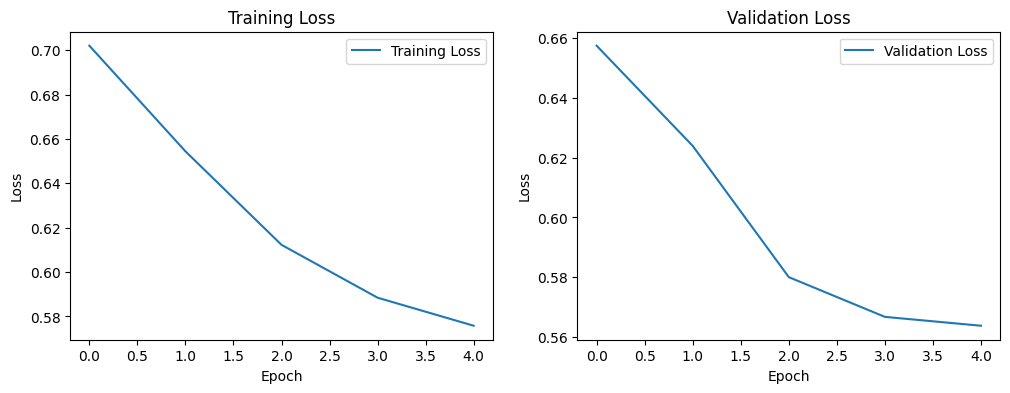

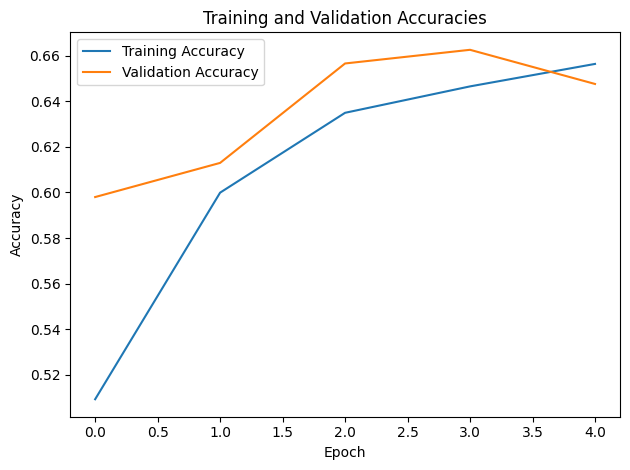

In [12]:
# Plotting losses
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(Loss_train, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Loss_val, label='Validation Loss')
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting accuracies
plt.plot(acc_train, label='Training Accuracy')
plt.plot(acc_val, label='Validation Accuracy')
plt.title('Training and Validation Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


#Test


## Save Moded

In [13]:
# Create a dictionary to store the checkpoint
checkpoint = {
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': Loss_train[-1]
}

checkpoint_path = 'checkpoint.pth'

# Save the checkpoint
torch.save(checkpoint, checkpoint_path)


In [14]:
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']


## Test

In [15]:
num_changed_samples=torch.tensor([0, 0, 0, 0]).to(device)   # first element is num image with no change,...
test_correct=torch.tensor([0,0,0,0]).to(device)


test_loss=0

for originals,transformeds,labels in tqdm.tqdm(test_loader):
  originals,transformeds,labels = originals.to(device),transformeds.to(device),labels.to(device)
  output=model(originals,transformeds)

  loss=citeration(output.to(torch.float32),labels.to(torch.float32))

  # Thresholding operation
  pred = (nn.functional.sigmoid(output)>0.5).int()
  labels=labels.to(int)

  test_loss += loss.item()

  num_changes=labels.sum(dim=1)
  unique_sums,counts=torch.unique(num_changes,return_counts=True)


  for i in range(len(unique_sums)):
    if unique_sums[i].item()==0:
        indices_0_changes=(num_changes==0).nonzero(as_tuple=True)[0]
        test_correct[0]+=torch.sum(torch.eq(pred[indices_0_changes], labels[indices_0_changes])).item()
        num_changed_samples[0]+=counts[i]

    elif unique_sums[i].item()==1:
        indices_1_changes=(num_changes==1).nonzero(as_tuple=True)[0]
        test_correct[1]+=torch.sum(torch.eq(pred[indices_1_changes], labels[indices_1_changes])).item()
        num_changed_samples[1]+=counts[i]

    elif unique_sums[i].item()==2:
        indices_2_changes=(num_changes==2).nonzero(as_tuple=True)[0]
        test_correct[2]+=torch.sum(torch.eq(pred[indices_2_changes], labels[indices_2_changes])).item()
        num_changed_samples[2]+=counts[i]

    else:
        indices_3_changes=(num_changes==3).nonzero(as_tuple=True)[0]
        test_correct[3]+=torch.sum(torch.eq(pred[indices_3_changes], labels[indices_3_changes])).item()
        num_changed_samples[3]+=counts[i]



test_acc=(test_correct.sum()).item() / (3*len(test_loader.dataset))
test_loss/=len(test_loader)


print(f' loss_test= {test_loss:.3f}, acc_test={test_acc*100}')



100%|██████████| 125/125 [01:36<00:00,  1.29it/s]

 loss_test= 0.565, acc_test=65.56666666666666


Given the training time on 5000 data points, the network has learned, and for achieving higher accuracy, it is necessary to utilize the entire dataset (it has been tested on all data points, but I forgot to save the results).







سوال تئوری:
بررسی کنید عکس ها با یک ،2 یا 3 تغییر کدام بهتر تشخیص داده میشوند؟

In [16]:
print(f"Accuracy on Image with 0 change: {(test_correct[0]/(3*num_changed_samples[0])).item()*100:.2f}")
print(f"Accuracy on Image with 1 change: {(test_correct[1]/(3*num_changed_samples[1])).item()*100:.2f}")
print(f"Accuracy on Image with 2 change: {(test_correct[2]/(3*num_changed_samples[2])).item()*100:.2f}")
print(f"Accuracy on Image with 3 change: {(test_correct[3]/(3*num_changed_samples[3])).item()*100:.2f}")

Accuracy on Image with 0 change: 95.07
Accuracy on Image with 1 change: 64.34
Accuracy on Image with 2 change: 56.57
Accuracy on Image with 3 change: 70.11


The more the number of changes, may the harder the detection becomes.
